<a href="https://colab.research.google.com/github/atomicguy/stereocards/blob/main/stereocard_training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Connect to Google Drive

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


# Install TensorFlow2 and Dependencies

In [2]:
import os
import pathlib

# Clone the tensorflow models repository if it doesn't already exist
if "models" in pathlib.Path.cwd().parts:
  while "models" in pathlib.Path.cwd().parts:
    os.chdir('..')
elif not pathlib.Path('models').exists():
  !git clone --depth 1 https://github.com/tensorflow/models

Cloning into 'models'...
remote: Enumerating objects: 2781, done.
remote: Counting objects: 100% (2781/2781), done.
remote: Compressing objects: 100% (2306/2306), done.
remote: Total 2781 (delta 712), reused 1315 (delta 440), pack-reused 0
Receiving objects: 100% (2781/2781), 32.76 MiB | 23.98 MiB/s, done.
Resolving deltas: 100% (712/712), done.


In [3]:
# Install the Object Detection API
%%bash
cd models/research/
protoc object_detection/protos/*.proto --python_out=.
cp object_detection/packages/tf2/setup.py .
python -m pip install .

Processing /content/models/research
  Created wheel for object-detection: filename=object_detection-0.1-cp37-none-any.whl size=1658497 sha256=f438e86324c4437b5c6a6c2e41c17160d97e181c664b337854036ccc3bb58b3b
  Stored in directory: /tmp/pip-ephem-wheel-cache-3gmgfr_3/wheels/94/49/4b/39b051683087a22ef7e80ec52152a27249d1a644ccf4e442ea
  Created wheel for avro-python3: filename=avro_python3-1.10.2-cp37-none-any.whl size=44011 sha256=75fda94036c3806b4812aa8538a2904c4ecd0b6866bb82b3dab0e3c69076e5c9
  Stored in directory: /root/.cache/pip/wheels/ee/ee/18/c466221ca6900e3efce2f4ea9c329288808679aecdcb2838d3
  Created wheel for future: filename=future-0.18.2-cp37-none-any.whl size=491070 sha256=5d12983710e124959a844f8cc4b4577c6f64e46681b055ad719731acf6bb8c55
  Stored in directory: /root/.cache/pip/wheels/8b/99/a0/81daf51dcd359a9377b110a8a886b3895921802d2fc1b2397e
  Created wheel for dill: filename=dill-0.3.1.1-cp37-none-any.whl size=78545 sha256=18b41984e3d8d4a35a02fd8687b81d9a223910f95e6e78086229

ERROR: multiprocess 0.70.12.2 has requirement dill>=0.3.4, but you'll have dill 0.3.1.1 which is incompatible.
ERROR: google-colab 1.0.0 has requirement requests~=2.23.0, but you'll have requests 2.25.1 which is incompatible.
ERROR: datascience 0.10.6 has requirement folium==0.2.1, but you'll have folium 0.8.3 which is incompatible.
ERROR: apache-beam 2.31.0 has requirement avro-python3!=1.9.2,<1.10.0,>=1.8.1, but you'll have avro-python3 1.10.2 which is incompatible.


In [5]:
import matplotlib
import matplotlib.pyplot as plt

import os
import random
import io
import imageio
import glob
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont
from IPython.display import display, Javascript
from IPython.display import Image as IPyImage

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.utils import colab_utils
from object_detection.builders import model_builder

%matplotlib inline

## Make Sure Everything is Setup

In [6]:
#run model builder test
!python /content/models/research/object_detection/builders/model_builder_tf2_test.py

2021-07-09 21:45:06.290578: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
Running tests under Python 3.7.10: /usr/bin/python3
[ RUN      ] ModelBuilderTF2Test.test_create_center_net_deepmac
2021-07-09 21:45:08.707214: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-09 21:45:08.775831: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-09 21:45:08.776843: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-07-09 21:45:08.776901: I tensorflow/stream_executor/platform/default/dso_loader.cc:5

# Get data from Roboflow

In [7]:
%cd /content
!curl -L "https://app.roboflow.com/ds/KoNuFmS2mC?key=U51HmkGDVK" > roboflow.zip; unzip roboflow.zip; rm roboflow.zip

/content
  % Total    % Received % Xferd  Average Speed   Time    Time     Time  Current
                                 Dload  Upload   Total   Spent    Left  Speed
100   891  100   891    0     0   1223      0 --:--:-- --:--:-- --:--:--  1222
100  240M  100  240M    0     0  50.3M      0  0:00:04  0:00:04 --:--:-- 71.5M
Archive:  roboflow.zip
 extracting: README.roboflow.txt     
   creating: test/
 extracting: test/image-pairs.tfrecord  
 extracting: test/image-pairs_label_map.pbtxt  
   creating: train/
 extracting: train/image-pairs.tfrecord  
 extracting: train/image-pairs_label_map.pbtxt  
   creating: valid/
 extracting: valid/image-pairs.tfrecord  
 extracting: valid/image-pairs_label_map.pbtxt  


In [8]:
# Set the record variable names
test_record_fname = '/content/test/image-pairs.tfrecord'
train_record_fname = '/content/train/image-pairs.tfrecord'
label_map_pbtxt_fname = '/content/train/image-pairs_label_map.pbtxt'

## Model List

In [9]:
##change chosen model to deploy different models available in the TF2 object detection zoo
MODELS_CONFIG = {
    'efficientdet-d0': {
        'model_name': 'efficientdet_d0_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d0_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d0_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d1': {
        'model_name': 'efficientdet_d1_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d1_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d1_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
    'efficientdet-d2': {
        'model_name': 'efficientdet_d2_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d2_768x768_coco17_tpu-8.config',
        'pretrained_checkpoint': 'efficientdet_d2_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d3': {
        'model_name': 'efficientdet_d3_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d3_896x896_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d3_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'efficientdet-d6': {
        'model_name': 'efficientdet_d6_coco17_tpu-32',
        'base_pipeline_file': 'ssd_efficientdet_d6_1408x1408_coco17_tpu-32.config',
        'pretrained_checkpoint': 'efficientdet_d6_coco17_tpu-32.tar.gz',
        'batch_size': 16
    },
        'ssd-resnet50': {
        'model_name': 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8',
        'base_pipeline_file': 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config',
        'pretrained_checkpoint': 'ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz',
        'batch_size': 8
    },
        'centernet-104': {
        'model_name': 'centernet_hg104_512x512_coco17_tpu-8',
        'base_pipeline_file': 'centernet_hourglass104_512x512_coco17_tpu-8.config',
        'pretrained_checkpoint': 'centernet_hg104_512x512_coco17_tpu-8.tar.gz',
        'batch_size': 8
    }
}

## Set Training Variables

In [10]:
#in this tutorial we implement the lightweight, smallest state of the art efficientdet model
#if you want to scale up tot larger efficientdet models you will likely need more compute!
chosen_model = 'ssd-resnet50'

num_steps = 40000 #The more steps, the longer the training. Increase if your loss function is still decreasing and validation metrics are increasing. 
num_eval_steps = 500 #Perform evaluation after so many steps

model_name = MODELS_CONFIG[chosen_model]['model_name']
pretrained_checkpoint = MODELS_CONFIG[chosen_model]['pretrained_checkpoint']
base_pipeline_file = MODELS_CONFIG[chosen_model]['base_pipeline_file']
batch_size = MODELS_CONFIG[chosen_model]['batch_size'] #if you can fit a large batch in memory, it may speed up your training

In [11]:
#download pretrained weights
%mkdir /content/models/research/deploy/
%cd /content/models/research/deploy/
import tarfile
download_tar = 'http://download.tensorflow.org/models/object_detection/tf2/20200711/' + pretrained_checkpoint

!wget {download_tar}
tar = tarfile.open(pretrained_checkpoint)
tar.extractall()
tar.close()

/content/models/research/deploy
--2021-07-09 21:46:16--  http://download.tensorflow.org/models/object_detection/tf2/20200711/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz
Resolving download.tensorflow.org (download.tensorflow.org)... 64.233.189.128, 2404:6800:4008:c07::80
Connecting to download.tensorflow.org (download.tensorflow.org)|64.233.189.128|:80... connected.
HTTP request sent, awaiting response... 200 OK
Length: 244817203 (233M) [application/x-tar]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’

ssd_resnet50_v1_fpn 100%[===================>] 233.48M  66.0MB/s    in 3.5s    

2021-07-09 21:46:20 (66.0 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.tar.gz’ saved [244817203/244817203]



In [12]:
#download base training configuration file
%cd /content/models/research/deploy
download_config = 'https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/' + base_pipeline_file
!wget {download_config}

/content/models/research/deploy
--2021-07-09 21:46:23--  https://raw.githubusercontent.com/tensorflow/models/master/research/object_detection/configs/tf2/ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.110.133, 185.199.111.133, 185.199.108.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.110.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 4528 (4.4K) [text/plain]
Saving to: ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config’

ssd_resnet50_v1_fpn 100%[===================>]   4.42K  --.-KB/s    in 0s      

2021-07-09 21:46:24 (42.0 MB/s) - ‘ssd_resnet50_v1_fpn_640x640_coco17_tpu-8.config’ saved [4528/4528]



## Set Config

In [13]:
#prepare
pipeline_fname = '/content/models/research/deploy/' + base_pipeline_file
fine_tune_checkpoint = '/content/models/research/deploy/' + model_name + '/checkpoint/ckpt-0'

def get_num_classes(pbtxt_fname):
    from object_detection.utils import label_map_util
    label_map = label_map_util.load_labelmap(pbtxt_fname)
    categories = label_map_util.convert_label_map_to_categories(
        label_map, max_num_classes=90, use_display_name=True)
    category_index = label_map_util.create_category_index(categories)
    return len(category_index.keys())

num_classes = get_num_classes(label_map_pbtxt_fname)

import re

%cd /content/models/research/deploy
print('writing custom configuration file')

with open(pipeline_fname) as f:
    s = f.read()
with open('pipeline_file.config', 'w') as f:
    
    # fine_tune_checkpoint
    s = re.sub('fine_tune_checkpoint: ".*?"',
               'fine_tune_checkpoint: "{}"'.format(fine_tune_checkpoint), s)
    
    # tfrecord files train and test.
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/train)(.*?")', 'input_path: "{}"'.format(train_record_fname), s)
    s = re.sub(
        '(input_path: ".*?)(PATH_TO_BE_CONFIGURED/val)(.*?")', 'input_path: "{}"'.format(test_record_fname), s)

    # label_map_path
    s = re.sub(
        'label_map_path: ".*?"', 'label_map_path: "{}"'.format(label_map_pbtxt_fname), s)

    # Set training batch_size.
    s = re.sub('batch_size: [0-9]+',
               'batch_size: {}'.format(batch_size), s)

    # Set training steps, num_steps
    s = re.sub('num_steps: [0-9]+',
               'num_steps: {}'.format(num_steps), s)
    
    # Set number of classes num_classes.
    s = re.sub('num_classes: [0-9]+',
               'num_classes: {}'.format(num_classes), s)
    
    #fine-tune checkpoint type
    s = re.sub(
        'fine_tune_checkpoint_type: "classification"', 'fine_tune_checkpoint_type: "{}"'.format('detection'), s)
        
    f.write(s)

pipeline_file = '/content/models/research/deploy/pipeline_file.config'
model_dir = '/content/training/'


/content/models/research/deploy
writing custom configuration file


In [14]:
# Take a look at the config

%cat /content/models/research/deploy/pipeline_file.config

# SSD with Resnet 50 v1 FPN feature extractor, shared box predictor and focal
# loss (a.k.a Retinanet).
# See Lin et al, https://arxiv.org/abs/1708.02002
# Trained on COCO, initialized from Imagenet classification checkpoint
# Train on TPU-8
#
# Achieves 34.3 mAP on COCO17 Val

model {
  ssd {
    inplace_batchnorm_update: true
    freeze_batchnorm: false
    num_classes: 2
    box_coder {
      faster_rcnn_box_coder {
        y_scale: 10.0
        x_scale: 10.0
        height_scale: 5.0
        width_scale: 5.0
      }
    }
    matcher {
      argmax_matcher {
        matched_threshold: 0.5
        unmatched_threshold: 0.5
        ignore_thresholds: false
        negatives_lower_than_unmatched: true
        force_match_for_each_row: true
        use_matmul_gather: true
      }
    }
    similarity_calculator {
      iou_similarity {
      }
    }
    encode_background_as_zeros: true
    anchor_generator {
      multiscale_anchor_generator {
        min_level: 3
        max_level: 7
 

# Train the Model

In [20]:
data_id = 'noise_rect_no_augment'
model_name = f'{data_id}-{chosen_model}'

!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --alsologtostderr \
    --num_train_steps=10000 \
    --sample_1_of_n_eval_examples=100 \
    --num_eval_steps=500

!cp -r /content/training /content/gdrive/MyDrive/tf2/{model_name}

2021-07-09 23:48:31.872824: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-09 23:48:34.733767: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-09 23:48:34.764856: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-09 23:48:34.765819: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-07-09 23:48:34.765875: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-09 23:48:34.769405: I tensorflow/stream_executor/pl

# Evaluate the Model

In [21]:
#run model evaluation to obtain performance metrics
!python /content/models/research/object_detection/model_main_tf2.py \
    --pipeline_config_path={pipeline_file} \
    --model_dir={model_dir} \
    --checkpoint_dir={model_dir} \

2021-07-10 01:34:54.233557: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
W0710 01:35:00.070691 139929366566784 model_lib_v2.py:1082] Forced number of epochs for all eval validations to be 1.
INFO:tensorflow:Maybe overwriting sample_1_of_n_eval_examples: None
I0710 01:35:00.070957 139929366566784 config_util.py:552] Maybe overwriting sample_1_of_n_eval_examples: None
INFO:tensorflow:Maybe overwriting use_bfloat16: False
I0710 01:35:00.071094 139929366566784 config_util.py:552] Maybe overwriting use_bfloat16: False
INFO:tensorflow:Maybe overwriting eval_num_epochs: 1
I0710 01:35:00.071242 139929366566784 config_util.py:552] Maybe overwriting eval_num_epochs: 1
W0710 01:35:00.071402 139929366566784 model_lib_v2.py:1103] Expected number of evaluation epochs is 1, but instead encountered `eval_on_train_input_config.num_epochs` = 0. Overwriting `num_epochs` to 1.
2021-07-10 01:35:00.083078: I tensorflow/stream_executor/

# Export Inference Graph

In [23]:
#run conversion script
import re
import numpy as np

output_directory = '/content/fine_tuned_model'

#place the model weights you would like to export here
last_model_path = '/content/training/'
print(last_model_path)
!python /content/models/research/object_detection/exporter_main_v2.py \
    --trained_checkpoint_dir {last_model_path} \
    --output_directory {output_directory} \
    --pipeline_config_path {pipeline_file}

/content/training/
2021-07-10 01:41:31.914583: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-10 01:41:34.257335: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcuda.so.1
2021-07-10 01:41:34.272973: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:937] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2021-07-10 01:41:34.273900: I tensorflow/core/common_runtime/gpu/gpu_device.cc:1733] Found device 0 with properties: 
pciBusID: 0000:00:04.0 name: Tesla P100-PCIE-16GB computeCapability: 6.0
coreClock: 1.3285GHz coreCount: 56 deviceMemorySize: 15.90GiB deviceMemoryBandwidth: 681.88GiB/s
2021-07-10 01:41:34.273945: I tensorflow/stream_executor/platform/default/dso_loader.cc:53] Successfully opened dynamic library libcudart.so.11.0
2021-07-10 01:41:34.277010: I tensorflow

In [35]:
!cp -r /content/fine_tuned_model /content/gdrive/MyDrive/tf2/ssd-resnet50-augment

# Test on Images

In [26]:
import matplotlib
import matplotlib.pyplot as plt

import io
import scipy.misc
import numpy as np
from six import BytesIO
from PIL import Image, ImageDraw, ImageFont

import tensorflow as tf

from object_detection.utils import label_map_util
from object_detection.utils import config_util
from object_detection.utils import visualization_utils as viz_utils
from object_detection.builders import model_builder

%matplotlib inline

def load_image_into_numpy_array(path):
  """Load an image from file into a numpy array.

  Puts image into numpy array to feed into tensorflow graph.
  Note that by convention we put it into a numpy array with shape
  (height, width, channels), where channels=3 for RGB.

  Args:
    path: the file path to the image

  Returns:
    uint8 numpy array with shape (img_height, img_width, 3)
  """
  img_data = tf.io.gfile.GFile(path, 'rb').read()
  image = Image.open(BytesIO(img_data))
  (im_width, im_height) = image.size
  return np.array(image.getdata()).reshape(
      (im_height, im_width, 3)).astype(np.uint8)

In [27]:
import os

#recover our saved model
pipeline_config = '/content/models/research/deploy/pipeline_file.config'
#generally you want to put the last ckpt from training in here
model_dir = '/content/training/ckpt-10'
configs = config_util.get_configs_from_pipeline_file(pipeline_config)
model_config = configs['model']
detection_model = model_builder.build(
      model_config=model_config, is_training=False)

# Restore checkpoint
ckpt = tf.compat.v2.train.Checkpoint(
      model=detection_model)
ckpt.restore(os.path.join('/content/training/ckpt-11'))


def get_model_detection_function(model):
  """Get a tf.function for detection."""

  @tf.function
  def detect_fn(image):
    """Detect objects in image."""

    image, shapes = model.preprocess(image)
    prediction_dict = model.predict(image, shapes)
    detections = model.postprocess(prediction_dict, shapes)

    return detections, prediction_dict, tf.reshape(shapes, [-1])

  return detect_fn

detect_fn = get_model_detection_function(detection_model)

In [28]:
#map labels for inference decoding
label_map_path = configs['eval_input_config'].label_map_path
label_map = label_map_util.load_labelmap(label_map_path)
categories = label_map_util.convert_label_map_to_categories(
    label_map,
    max_num_classes=label_map_util.get_max_label_map_index(label_map),
    use_display_name=True)
category_index = label_map_util.create_category_index(categories)
label_map_dict = label_map_util.get_label_map_dict(label_map, use_display_name=True)

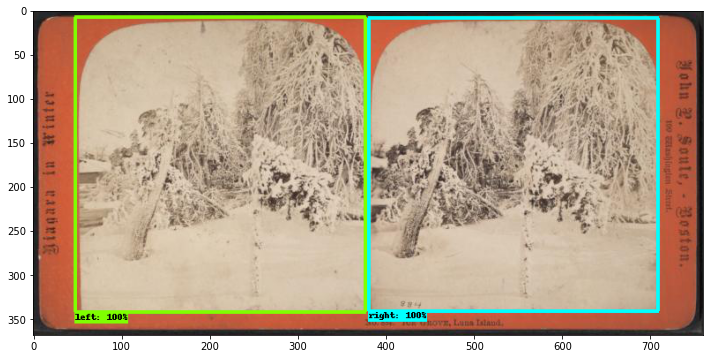

In [34]:
#run detector on test image
#it takes a little longer on the first run and then runs at normal speed. 
import random
import glob

TEST_IMAGE_PATHS = glob.glob('/content/gdrive/MyDrive/NYPL_stereoviews/w_size/validate/*.jpg')
image_path = random.choice(TEST_IMAGE_PATHS)
image_np = load_image_into_numpy_array(image_path)

# Things to try:
# Flip horizontally
# image_np = np.fliplr(image_np).copy()

# # Convert image to grayscale
# image_np = np.tile(
#     np.mean(image_np, 2, keepdims=True), (1, 1, 3)).astype(np.uint8)

input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
detections, predictions_dict, shapes = detect_fn(input_tensor)

label_id_offset = 1
image_np_with_detections = image_np.copy()

viz_utils.visualize_boxes_and_labels_on_image_array(
      image_np_with_detections,
      detections['detection_boxes'][0].numpy(),
      (detections['detection_classes'][0].numpy() + label_id_offset).astype(int),
      detections['detection_scores'][0].numpy(),
      category_index,
      use_normalized_coordinates=True,
      max_boxes_to_draw=200,
      min_score_thresh=.5,
      agnostic_mode=False,
)

plt.figure(figsize=(12,16))
plt.imshow(image_np_with_detections)
plt.show()

In [77]:
def filter_boxes(detections, max_boxes=2, min_score_thresh=0.5):
  boxes = detections['detection_boxes'][0].numpy()
  classes = (detections['detection_classes'][0].numpy() + label_id_offset).astype(int)
  scores = detections['detection_scores'][0].numpy()

  filtered_boxes = []

  for i in range(boxes.shape[0]):
    prediction = {}
    if scores is None or scores[i] > min_score_thresh:
      box = boxes[i].tolist()
      display_str = ''
      if classes[i] in six.viewkeys(category_index):
        class_name = category_index[classes[i]]['name']
      else:
        class_name = 'N/A'
      score = scores[i]
      prediction['box'] = box
      prediction['class'] = class_name
      prediction['score'] = score
      filtered_boxes.append(prediction)
  
  return filtered_boxes


In [90]:
import glob
from pathlib import Path

test_image_paths = glob.glob('/content/gdrive/MyDrive/NYPL_stereoviews/w_size/validate/*.jpg')

images = []

for image in test_image_paths:
  image_np = load_image_into_numpy_array(image)
  input_tensor = tf.convert_to_tensor(
    np.expand_dims(image_np, 0), dtype=tf.float32)
  detections, _, _ = detect_fn(input_tensor)

  results = filter_boxes(detections)
  uuid = Path(image).stem

  predictions = {'uuid': uuid,
                 'boxes': results}

  images.append(predictions)

In [91]:
images

[{'boxes': [{'box': [0.060509324073791504,
     0.11061131954193115,
     0.8962439298629761,
     0.5062607526779175],
    'class': 'left',
    'score': 0.9997949},
   {'box': [0.059773772954940796,
     0.5114539861679077,
     0.8975659608840942,
     0.8925015926361084],
    'class': 'right',
    'score': 0.99775285}],
  'uuid': '4bb517f0-c55d-012f-8092-58d385a7bc34'},
 {'boxes': [{'box': [0.04876267910003662,
     0.0912252813577652,
     0.8739506602287292,
     0.5025299787521362],
    'class': 'left',
    'score': 0.99949014},
   {'box': [0.0481543242931366,
     0.5009069442749023,
     0.8728948831558228,
     0.907418966293335],
    'class': 'right',
    'score': 0.99901664}],
  'uuid': 'd7dc7e10-c56b-012f-1424-58d385a7bc34'},
 {'boxes': [{'box': [0.08328321576118469,
     0.10056395828723907,
     0.8689961433410645,
     0.499223530292511],
    'class': 'left',
    'score': 0.99996436},
   {'box': [0.06843110918998718,
     0.5057865381240845,
     0.8570480346679688,
    

In [84]:
Path(test_image_paths[0]).stem

'4bb517f0-c55d-012f-8092-58d385a7bc34'

In [89]:
len(test_image_paths)

200